In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [20]:
from azureml.core import Workspace, Dataset, Datastore
workspace = Workspace.from_config()
output = {}
output['Subscription ID'] = workspace.subscription_id
output['Workspace Name'] = workspace.name
output['Resource Group'] = workspace.resource_group
output['Location'] = workspace.location
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,7ca151c5-e4f7-4663-9583-834f4e0e6ed4
Workspace Name,houston-techsummit-workspace
Resource Group,calcutta_demos
Location,eastus2


In [5]:
#Get the yelp Dataset from adlsgen2
dataset_yelp_review = Dataset.get_by_name(workspace, 'yelp_review')
#Convert to Pandas Dataframe
df_yelp_review = dataset_yelp_review.to_pandas_dataframe()

In [6]:
# Create new column "Actual_Sentiment" that stored 0's or 1's
# 0 being Negative, 1 being Positive
df_yelp_review['Actual_Sentiment'] = (
    np.select(
        condlist=[df_yelp_review['stars'] > 3], 
        choicelist=[1], 
        default=0))

In [7]:
#The only challenge that we’ve faced was about balancing the train dataset in terms of having the equal 
#numbers of positive and negative reviews for our two classes. 
#Break it into positive and negative sentiment dataframes
df_yelp_review_negative = df_yelp_review.loc[df_yelp_review['Actual_Sentiment']==0]
df_yelp_review_positive = df_yelp_review.loc[df_yelp_review['Actual_Sentiment']==1]
#Select a subset of the positive and negative sentiment dataframes
df_yelp_review_negative = df_yelp_review_negative[:50000]
df_yelp_review_positive = df_yelp_review_positive[:50000]
#Merge the positive and negative sentiment dataframes
all_df = [df_yelp_review_negative, df_yelp_review_positive]
df_yelp_review_balanced = pd.concat(all_df)

In [8]:
#We only need the text (review) and Actual_Sentiment columns for sentiment prediction
df_ml_yelp_review = df_yelp_review_balanced[['text','Actual_Sentiment']]

In [9]:
df_ml_yelp_review['Actual_Sentiment'].value_counts()

1    50000
0    50000
Name: Actual_Sentiment, dtype: int64

In [10]:
#Build punctuation dictionary
import unicodedata
import sys

# Create a dictionary of punctuation characters
punctuation = dict.fromkeys(i for i in range(sys.maxunicode)
                            if unicodedata.category(chr(i)).startswith('P'))
# Add the backtick/ Grave accent character
punctuation.update({96:None})

In [11]:
#Let us clean up and make the data ready
#Now it is time to preprocess the reviews because all these modifications will directly affect the classifier’s performance.
# As we are going to use words as features so we can use some text formatting techniques which will help us in feature extraction
#  including removing punctuation marks/digits ,and also stop-words. In addition, the implementation of 
# lemmatization words using NLTK
#   can be workable to maximize the performance. Tokenization is the last step to break reviews up into
#  words and other meaningful tokens.

import re 
import string
#pip install nltk
import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def function_clean_stop(text):
    #convert into lowercase
    text = text.lower()
    #removing the URL Http
    text = re.sub(r"http\S+", "", text) 
    # Removal of mentions
    #text = re.sub("@[^\s]*", "", text)
    # Removal of hashtags
    #text = re.sub("#[^\s]*", "", text)
    # Removal of numbers
    text = re.sub('[0-9]*[+-:]*[0-9]+', '', text)
    text = re.sub("'s", "", text)   
    #remove all punctuation from the text.
    text = str(text.translate(punctuation))
    
    listofwords = text.strip().split()          # to remove any space from beginning and the end of text
    tokenized_words = []    
    for word in listofwords:
        if not word in ENGLISH_STOP_WORDS:
            lemm_word = WordNetLemmatizer().lemmatize(word)
            if len(lemm_word)>0:
                tokenized_words.append(lemm_word)
    return_str = ' '.join([str(elem) for elem in tokenized_words])             
    return(return_str)

In [12]:
# applying the cleaning function to text column
df_ml_yelp_review['text'] = df_ml_yelp_review['text'].apply(lambda text: function_clean_stop(text))

In [15]:
#Splitting the data to train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_ml_yelp_review["text"]
y = df_ml_yelp_review["Actual_Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [16]:
#Vectorizing the text using TF_IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vect_1 = TfidfVectorizer(min_df=100, stop_words={'english'}, ngram_range=(1,3)).fit(X_train)
X_train1 = vect_1.transform(X_train)
X_test1 = vect_1.transform(X_test)

In [22]:
np.logspace(0, 4, 10)

array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04])

In [24]:
[10**j for j in range(-4,4)]

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [26]:
np.logspace(0, 4, 8)

array([1.00000000e+00, 3.72759372e+00, 1.38949549e+01, 5.17947468e+01,
       1.93069773e+02, 7.19685673e+02, 2.68269580e+03, 1.00000000e+04])

In [27]:
#Create a dictionary of candidate learning algorithms and their hyperparameters: 
# Load libraries
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from time import time
import logging

# Set random seed
np.random.seed(0)

# Load data
features = df_ml_yelp_review["text"]
target = df_ml_yelp_review["Actual_Sentiment"]

# Create a pipeline
#pipe = Pipeline([("classifier", RandomForestClassifier())])
# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipe = Pipeline([
    ('tfidfvect', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

# Create dictionary with candidate learning algorithms and their hyperparameters
search_space = [{
                'tfidfvect__max_df': (0.5, 0.75, 1.0),
                'tfidfvect__max_features': (None, 5000, 10000, 50000),
                'tfidfvect__ngram_range': ((1, 1), (1, 2), (1, 3)),
                'tfidfvect__use_idf': (True, False),
                'tfidfvect__norm': ('l1', 'l2'),
                "classifier": [LogisticRegression()],
                "classifier__penalty": ['l1', 'l2'],
                "classifier__C": np.logspace(0, 4, 10)},.
                "classifier__C": [10**j for j in range(-4,4)]},
                "classifier__solver": ['newton-cg', 'lbfgs','saga']},
                {
                'tfidfvect__max_df': (0.5, 0.75, 1.0),
                'tfidfvect__max_features': (None, 5000, 10000, 50000),
                'tfidfvect__ngram_range': ((1, 1), (1, 2), (1, 3)),
                'tfidfvect__use_idf': (True, False),
                'tfidfvect__norm': ('l1', 'l2'),
                "classifier": [RandomForestClassifier()],
                "classifier__n_estimators": [10, 100, 1000]},
				{
                'tfidfvect__max_df': (0.5, 0.75, 1.0),
                'tfidfvect__max_features': (None, 5000, 10000, 50000),
                'tfidfvect__ngram_range': ((1, 1), (1, 2), (1, 3)),
                'tfidfvect__use_idf': (True, False),
                'tfidfvect__norm': ('l1', 'l2'),
                "classifier": [XGBClassifier()],
                "classifier__max_depth": [3,4,5,6,7,8,9,10]},
				{
                'tfidfvect__max_df': (0.5, 0.75, 1.0),
                'tfidfvect__max_features': (None, 5000, 10000, 50000),
                'tfidfvect__ngram_range': ((1, 1), (1, 2), (1, 3)),
                'tfidfvect__use_idf': (True, False),
                'tfidfvect__norm': ('l1', 'l2'),
                "classifier": [MLPClassifier()],
                "classifier__hidden_layer_sizes":(30,30,30)}]

# Create grid search
#gridsearch = GridSearchCV(pipe, search_space, cv=5, n_jobs=-1, verbose=3)

# Fit grid search
#best_model = gridsearch.fit(features, target)
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    gridsearch = GridSearchCV(pipe, search_space, cv=2, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipe.steps])
    print("parameters:")
    pprint(search_space)
    t0 = time()
    # Fit grid search
    best_model = gridsearch.fit(features, target)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best score: %0.3f" % gridsearch.best_score_)
    print("Best parameters set:")
    #Model prameters
    print(best_model.best_estimator_.get_params()["classifier"])

Performing grid search...
pipeline: ['tfidfvect', 'classifier']
parameters:
[{'classifier': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)],
  'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
  'tfidfvect__max_df': (0.5, 0.75, 1.0),
  'tfidfvect__ngram_range': ((1, 1), (1, 2), (1, 3))},
 {'classifier': [RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed: 80.5min finished


In [ ]:
[{'classifier': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)],

In [34]:
# fitting a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Fitting Logistic regression to the training set
logreg = LogisticRegression(C=1.0, solver='lbfgs', penalty='l2', multi_class='auto',random_state=1)
logreg.fit(X_train1, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
cv_logreg_train_accuracy = cross_val_score(logreg, X_train1, y_train, cv=10, scoring="accuracy")
cv_logreg_train_accuracy_mean = "%0.2f"%cv_logreg_train_accuracy.mean()
cv_logreg_train_accuracy_std = "%0.2f"%cv_logreg_train_accuracy.std()
cv_logreg_test_accuracy = cross_val_score(logreg, X_test1, y_test, cv=5, scoring="accuracy")
cv_logreg_test_accuracy_mean = "%0.2f"%cv_logreg_test_accuracy.mean()
cv_logreg_test_accuracy_std = "%0.2f"%cv_logreg_test_accuracy.std()

cv_logreg_train_precision = cross_val_score(logreg, X_train1, y_train, cv=10, scoring="precision")
cv_logreg_train_precision_mean = "%0.2f"%cv_logreg_train_precision.mean()
cv_logreg_train_precision_std = "%0.2f"%cv_logreg_train_precision.std()
cv_logreg_test_precision = cross_val_score(logreg, X_test1, y_test, cv=5, scoring="precision")
cv_logreg_test_precision_mean = "%0.2f"%cv_logreg_test_precision.mean()
cv_logreg_test_precision_std = "%0.2f"%cv_logreg_test_precision.std()

cv_logreg_train_recall = cross_val_score(logreg, X_train1, y_train, cv=10, scoring="recall")
cv_logreg_train_recall_mean = "%0.2f"%cv_logreg_train_recall.mean()
cv_logreg_train_recall_std = "%0.2f"%cv_logreg_train_recall.std()
cv_logreg_test_recall = cross_val_score(logreg, X_test1, y_test, cv=5, scoring="recall")
cv_logreg_test_recall_mean = "%0.2f"%cv_logreg_test_recall.mean()
cv_logreg_test_recall_std = "%0.2f"%cv_logreg_test_recall.std()

cv_logreg_train_f1 = cross_val_score(logreg, X_train1, y_train, cv=10, scoring="f1")
cv_logreg_train_f1_mean = "%0.2f"%cv_logreg_train_f1.mean()
cv_logreg_train_f1_std = "%0.2f"%cv_logreg_train_f1.std()
cv_logreg_test_f1 = cross_val_score(logreg, X_test1, y_test, cv=5, scoring="f1")
cv_logreg_test_f1_mean = "%0.2f"%cv_logreg_test_f1.mean()
cv_logreg_test_f1_std = "%0.2f"%cv_logreg_test_f1.std()


print ("-----------------Detailed Cross Validated Model Evaluation Metrics-----------------")
print ("-------------------------------Logistic Regression---------------------------------")
print ("-------------------------------------Accuracy-------------------------------------")
print ("Training CV accuracy score with 10 cross folds",cv_logreg_train_accuracy)
print ("Training CV accuracy average score",cv_logreg_train_accuracy_mean)
print ("Training CV accuracy standard deviation",cv_logreg_train_accuracy_std)
print ("Test CV accuracy score with 5 cross folds",cv_logreg_test_accuracy)
print ("Test CV accuracy average score",cv_logreg_test_accuracy_mean)
print ("Test CV accuracy standard deviation",cv_logreg_test_accuracy_std)
print ("-----------------------------------------------------------------------------------")
print ("-------------------------------------Precision-------------------------------------")
print ("Training CV precision score with 10 cross folds",cv_logreg_train_precision)
print ("Training CV precision average score",cv_logreg_train_precision_mean)
print ("Training CV precision standard deviation",cv_logreg_train_precision_std)
print ("Test CV precision score with 5 cross folds",cv_logreg_test_precision)
print ("Test CV precision average score",cv_logreg_test_precision_mean)
print ("Test CV precision standard deviation",cv_logreg_test_precision_std)
print ("-----------------------------------------------------------------------------------")
print ("-------------------------------------Recall----------------------------------------")
print ("Training CV recall score with 10 cross folds",cv_logreg_train_recall)
print ("Training CV recall average score",cv_logreg_train_recall_mean)
print ("Training CV recall standard deviation",cv_logreg_train_recall_std)
print ("Test CV recall score with 5 cross folds",cv_logreg_test_recall)
print ("Test CV recall average score",cv_logreg_test_recall_mean)
print ("Test CV recall standard deviation",cv_logreg_test_recall_std)
print ("-----------------------------------------------------------------------------------")
print ("-------------------------------------F1--------------------------------------------")
print ("Training CV F1 score with 10 cross folds",cv_logreg_train_f1)
print ("Training CV F1 average score",cv_logreg_train_f1_mean)
print ("Training CV F1 standard deviation",cv_logreg_train_f1_std)
print ("Test CV F1 score with 5 cross folds",cv_logreg_test_f1)
print ("Test CV F1 average score",cv_logreg_test_f1_mean)
print ("Test CV F1 standard deviation",cv_logreg_test_f1_std)
print ("-----------------------------------------------------------------------------------")

-----------------Detailed Cross Validated Model Evaluation Metrics-----------------
-------------------------------Logistic Regression---------------------------------
-------------------------------------Accuracy-------------------------------------
Training CV accuracy score with 10 cross folds [0.888625 0.8845   0.884875 0.8915   0.88675  0.890625 0.88975  0.888375
 0.888375 0.886875]
Training CV accuracy average score 0.89
Training CV accuracy standard deviation 0.00
Test CV accuracy score with 5 cross folds [0.8815 0.886  0.8775 0.8785 0.881 ]
Test CV accuracy average score 0.88
Test CV accuracy standard deviation 0.00
-----------------------------------------------------------------------------------
-------------------------------------Precision-------------------------------------
Training CV precision score with 10 cross folds [0.89009054 0.88545592 0.87851158 0.89150589 0.88271758 0.88897206
 0.88841737 0.89483066 0.88694784 0.88088779]
Training CV precision average score 0.8

In [38]:
# Predicting the test set results
y_pred_logreg = logreg.predict(X_test1)

# Training score
print(f"Score on training set: {logreg.score(X_train1,y_train)}")
print(f"Score on test set: {logreg.score(X_test1,y_test)}")

Score on training set: 0.905
Score on test set: 0.8926


In [41]:
from sklearn.metrics import classification_report
y_pred_logreg = logreg.predict(X_test1)
# Create a classification report
class_names = ['Negative Review','Positive Review']
print(classification_report(y_test,y_pred_logreg,
                            target_names=class_names))

                 precision    recall  f1-score   support

Negative Review       0.90      0.89      0.89      9934
Positive Review       0.89      0.90      0.89     10066

       accuracy                           0.89     20000
      macro avg       0.89      0.89      0.89     20000
   weighted avg       0.89      0.89      0.89     20000



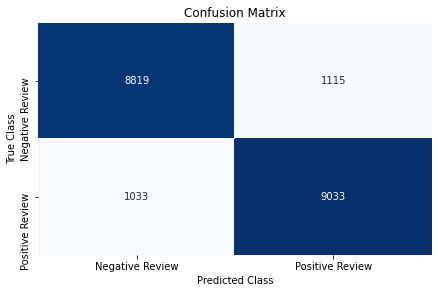

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_names = ['Negative Review','Positive Review']

# Train model and make predictions
target_predicted = logreg.fit(X_train1,y_train).predict(X_test1)

# Create confusion matrix
matrix = confusion_matrix(y_test, target_predicted)

# Create pandas dataframe
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='d')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

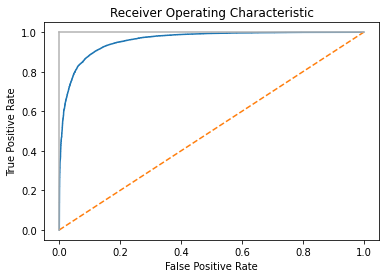

In [45]:
# Load libraries
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities
target_probabilities = logreg.predict_proba(X_test1)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,
                                                               target_probabilities)

# Plot ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()					

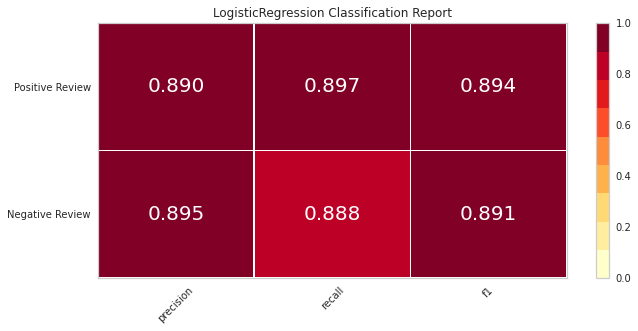

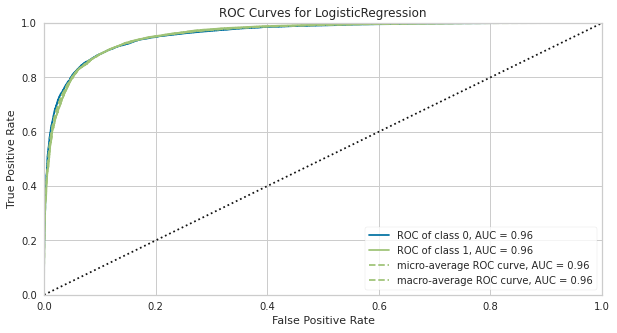

In [51]:
# Precision, Recall, and F1 Score
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(logreg, classes=class_names)
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.fit(X_train1, y_train) # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(logreg)

visualizer.fit(X_train1, y_train) # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
plt.rcParams['font.size'] = 20
g = visualizer.poof()